# Assignment 2 :

TEAM-ID:  19 <br>
TEAM-NAME: mr01

In [29]:
import numpy as np
import open3d as o3d
import os 
import glob
import copy
import shutil
import matplotlib.pyplot as plt
from collections import Counter

In [30]:
class Question_2:
    def __init__(self):
        self.gmap = np.zeros((170,170))
        self.pcd_loc = 'data/input_data/01'
        self.pose_file = 'data/input_data/01.txt'
        self.save_ocmap_loc = 'data/output_data/'
        
    def readData(self, filename):
        """
        reads the ground truth file 
        returns a 2D array with each 
        row as GT pose(arranged row major form)
        array size should be 1101*12
        """
        data = np.loadtxt(filename)
        #data[i].reshape(3,4)
        return data 


    def readPointCloud(self, filename):
        """
        reads bin file and returns
        as m*4 np array
        all points are in meters
        you can filter out points beyond(in x y plane)
        50m for ease of computation
        and above or below 10m
        """
        pcl = np.fromfile(filename, dtype=np.float32,count=-1)
        pcl = pcl.reshape([-1,4])
        return pcl
        
    def convert_to_pcd(self, point):
        remain_points = []
        for pt in point:
            x,y,z,_ = pt
            trans = [x,y,z]
            remain_points.append(trans)

        if remain_points:       
            np_pcd = np.asarray(remain_points)
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(np_pcd)
            return pcd
        
    def transformation_from_pose(self, pose):
        Transformation = pose.reshape((3,4))
        return Transformation

    def rotate(self, R, points):
        return (R @ points.T).T

    def translate(self, T, points):
        return points + T

    def transformed_point_cloud(self, Transformation,pcds_down):
        #pcds_down_r = copy.deepcopy(pcds_down)
        R = Transformation[0:3 ,0:3]
        T = Transformation[0:3,3]
        #pcds_down_r.rotate(R, center=(0,0,0))
        #pcds_down_mv = copy.deepcopy(pcds_down_r).translate(T, relative=True)
        data = np.asarray(pcds_down.points)
        data = self.rotate(R, data)
        data = self.translate(T, data)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data)
        return pcd

    def convert_world_frame(self, pcd):
        #R = np.array([[0,0,1],[0,-1,0],[1,0,0]])
        R = np.array([[1,0,0],[0,0,-1],[0,-1,0]])
        data = np.asarray(pcd.points)
        data = self.rotate(R, data)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data)
        return pcd
    
    def convert_camera_frame(self, pcd):
        T = np.array([[0, -1, 0, 0], [0, 0, -1, 0], [1, 0, 0, 0],[0, 0, 0, 1]])
        pcd.transform(T)
        return pcd
    
    def ocmap_count(self, ocmap, points, map_w, map_h):
        #print(ocmap.shape)
        #ocmap = []
        w,h = map_w//2, map_h//2
        for pt in points:
            x, y, z = pt
            ocmap[y+w, x+h] = 255
            #ocmap.append([x,y])
            if self.gmap[y+w, x+h] == 0:
                self.gmap[y+w, x+h] = 255
          
        return ocmap
        
    def PointCloud_Registration(self):
        '''
        Call function : PointCloud_Registration
        Return : Drawing Geometry
        Paramters : None
        '''
        print('Running Question 2.1 : Point Cloud Registration')
        voxel_size = 2
        pcd_combined = o3d.geometry.PointCloud()
        
        # Reading poses
        pose = self.readData(self.pose_file)
        pose = pose[:77,:]
        for k,f1 in enumerate(glob.glob(os.path.join(self.pcd_loc,'*.bin'))):
            
            # Read lidar points from each bin in sequence
            file1 = self.readPointCloud(f1)
            
            # Convert the points into point cloud
            pcd = self.convert_to_pcd(file1)
            
            # Transform the pointcloud from lidar frame to image frame
            #pcd.transform([[0, -1, 0, 0], [0, 0, -1, 0], [1, 0, 0, 0], [0, 0, 0, 1]])
            pcd = self.convert_camera_frame(pcd)
            pcds_down = copy.deepcopy(pcd)
            
            # Apply transformation to point clouds from pose file
            trans_matrix = self.transformation_from_pose(pose[k])
            pcd_trans = self.transformed_point_cloud(trans_matrix,pcds_down)
    
            # Combine point clouds from every bin
            pcd_combined += pcd_trans
            
            print('File '+str(k+1)+' processed..')
    
        # Transform the point cloud again into world frame for visualization
        #R = np.array([[1,0,0],[0,0,-1],[0,-1,0]])
        #pcd_combined.rotate(R, center=(0,0,0))
        pcd_combined = self.convert_world_frame(pcd_combined)
        output = pcd_combined.voxel_down_sample(voxel_size)
        #o3d.visualization.draw_geometries([output])
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(output)
        vis.run()
        vis.capture_screen_image('data/output_data/pointcloud_registration.png')
        vis.destroy_window()
        
    def OccupancyMap(self, num_of_bins = 5, threshold = 150):
        '''
        Call function : OccupancyMap
        Return : Save the occupancy map
        Paramters : num_of_bins - how many bins to process
                    threshold - threshold to set for identified occupied regions
                    #start_idx - from which bin file to start processing in range[0-77]
        '''
        
        pose = self.readData(self.pose_file)
        pose = pose[:77,:]
        combine = []
        print('Running Question 2.2 : Occupancy Grid Map')
        print("Number of bins to process : ", num_of_bins)
        print("Threshold : ", threshold)
        parent_dir = self.save_ocmap_loc
        directory = 'OccupancyMap_for_'+str(num_of_bins)+'_bins'
        path = os.path.join(parent_dir, directory) 
        shutil.rmtree(path, ignore_errors=True)
        os.makedirs(path) 
        
        for k,f1 in enumerate(glob.glob(os.path.join(self.pcd_loc,'*.bin'))):
            if k > num_of_bins - 1:
                break
                
            # Read lidar points from each bin in sequence
            # Convert the points into point cloud
            # Transform the pointcloud from lidar frame to image frame
            # Apply transformation to point clouds from pose file
            points = self.readPointCloud(f1)
            points = self.convert_to_pcd(points)
            points = self.convert_camera_frame(points)
            trans_matrix = self.transformation_from_pose(pose[k])
            points = self.transformed_point_cloud(trans_matrix, points)
            R = np.array([[1,0,0],[0,0,-1],[0,-1,0]])
            points.rotate(R, center=(0,0,0))
            
            # Convert point clouds to numpy array for processing
            points = np.asarray(points.points)
            points = points.astype(int)
            
            # Taking 2 axis x and y from points
            point_2d = np.asarray([[pt[0],pt[1]] for pt in points])
             
            # finding distinct x,y points with number of their counts
            unique_elements, counts_elements = np.unique(points, axis = 0, return_counts = True)
            
            # getting index positions and extraction of points which have greater than threshold count
            idx = [i for i,count in enumerate(counts_elements) if count >= threshold]
            point_extract = points[idx]
            
            '''
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(point_extract)
            o3d.visualization.draw_geometries([pcd])
            '''
            # Saving each bin file occupancy map 
            map_w, map_h = max(points[:,0])-min(points[:,0])+1, max(points[:,1])-min(points[:,1])+1
            ocmap = np.zeros((200, 200))
            ocmap = self.ocmap_count(ocmap, point_extract, map_w, map_h)
            plt.imsave(path+'/omap_image_'+str(k+1)+'.png',ocmap, cmap = 'gray', dpi = 100)
            print('File '+str(k+1)+' processed..')
            
        # Saving global occupancy map
        plt.imsave(path+'/Final_OMap_'+str(num_of_bins)+'_bins.png',self.gmap, cmap = 'gray', dpi = 100)
        print('Finished entire sequence and occupancy map generated and saved at location : '+str(path)) 
        

    

## Task 1 - Point Cloud Registration


In [37]:
obj = Question_2()
obj.PointCloud_Registration()

Running Question 2.1 : Point Cloud Registration
File 1 processed..
File 2 processed..
File 3 processed..
File 4 processed..
File 5 processed..
File 6 processed..
File 7 processed..
File 8 processed..
File 9 processed..
File 10 processed..
File 11 processed..
File 12 processed..
File 13 processed..
File 14 processed..
File 15 processed..
File 16 processed..
File 17 processed..
File 18 processed..
File 19 processed..
File 20 processed..
File 21 processed..
File 22 processed..
File 23 processed..
File 24 processed..
File 25 processed..
File 26 processed..
File 27 processed..
File 28 processed..
File 29 processed..
File 30 processed..
File 31 processed..
File 32 processed..
File 33 processed..
File 34 processed..
File 35 processed..
File 36 processed..
File 37 processed..
File 38 processed..
File 39 processed..
File 40 processed..
File 41 processed..
File 42 processed..
File 43 processed..
File 44 processed..
File 45 processed..
File 46 processed..
File 47 processed..
File 48 processed..
F

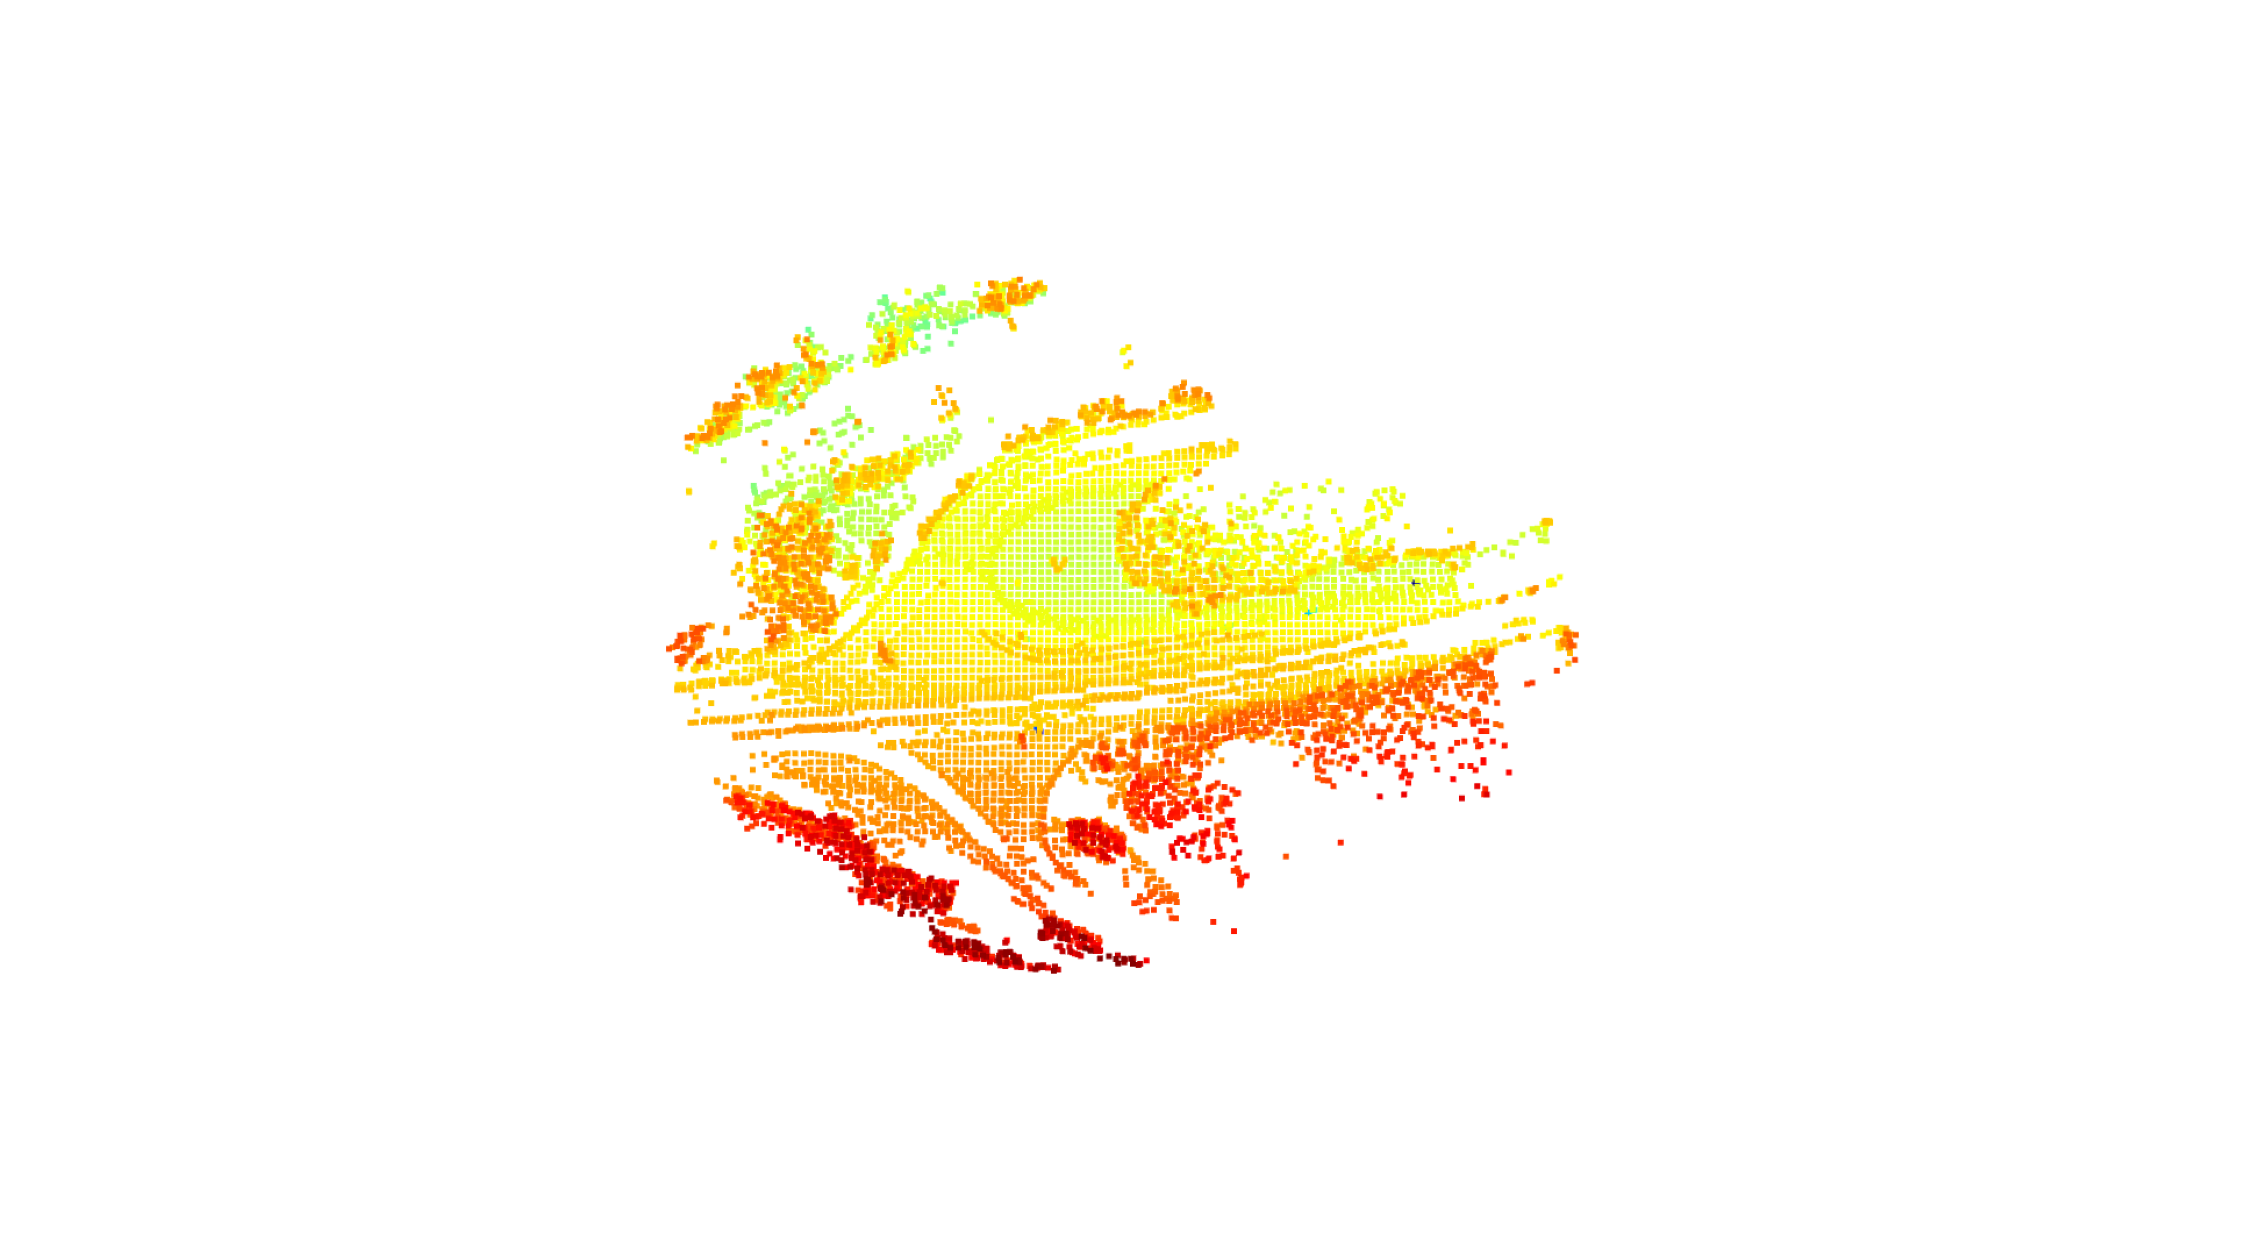

In [36]:
img = plt.imread('data/output_data/pointcloud_registration.png')
plt.figure(figsize = (40,40))
plt.axis('off')
plt.imshow(img)

## Task 2 - Occupancy Grid Construction

Running Question 2.2 : Occupancy Grid Map
Number of bins to process :  5
Threshold :  200
File 1 processed..
File 2 processed..
File 3 processed..
File 4 processed..
File 5 processed..
Finished entire sequence and occupancy map generated and saved at location : data/output_data/OccupancyMap_for_5_bins


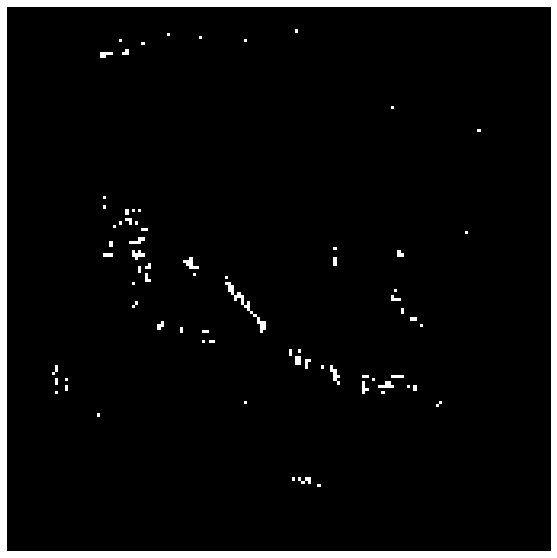

In [33]:
obj = Question_2()
obj.OccupancyMap(5, 200) # OccupancyMap(num_of_bins = default(5), threshold = default(150))
img = plt.imread('data/output_data/OccupancyMap_for_5_bins/Final_OMap_5_bins.png')
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(img)

Running Question 2.2 : Occupancy Grid Map
Number of bins to process :  10
Threshold :  200
File 1 processed..
File 2 processed..
File 3 processed..
File 4 processed..
File 5 processed..
File 6 processed..
File 7 processed..
File 8 processed..
File 9 processed..
File 10 processed..
Finished entire sequence and occupancy map generated and saved at location : data/output_data/OccupancyMap_for_10_bins


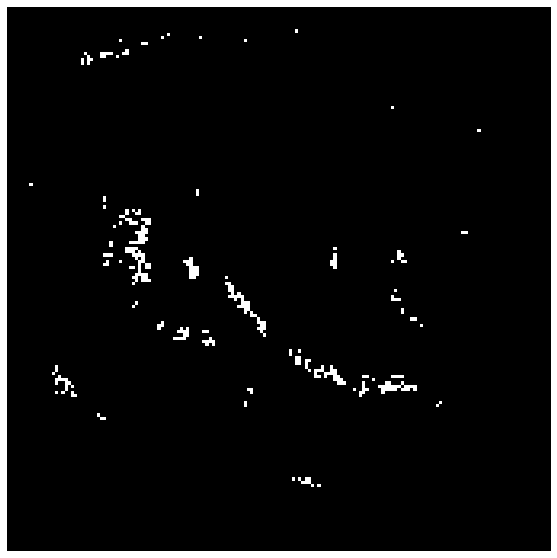

In [34]:
obj.OccupancyMap(10, 200) # OccupancyMap(num_of_bins = default(5), threshold = default(150))
img = plt.imread('data/output_data/OccupancyMap_for_10_bins/Final_OMap_10_bins.png')
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(img)

Running Question 2.2 : Occupancy Grid Map
Number of bins to process :  15
Threshold :  200
File 1 processed..
File 2 processed..
File 3 processed..
File 4 processed..
File 5 processed..
File 6 processed..
File 7 processed..
File 8 processed..
File 9 processed..
File 10 processed..
File 11 processed..
File 12 processed..
File 13 processed..
File 14 processed..
File 15 processed..
Finished entire sequence and occupancy map generated and saved at location : data/output_data/OccupancyMap_for_15_bins


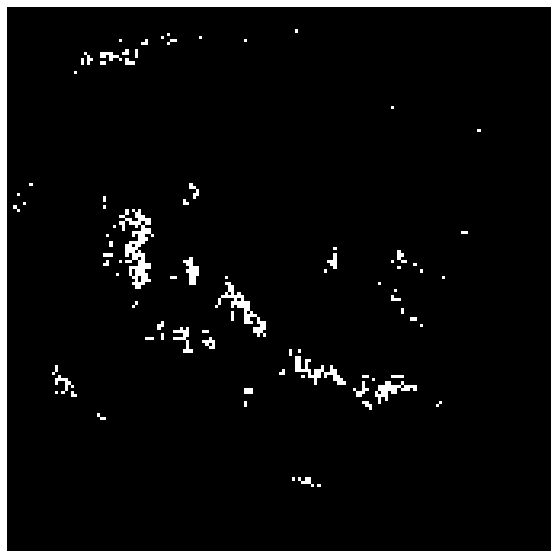

In [35]:
obj.OccupancyMap(15, 200) # OccupancyMap(num_of_bins = default(5), threshold = default(150))
img = plt.imread('data/output_data/OccupancyMap_for_15_bins/Final_OMap_15_bins.png')
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(img)